# 编程实践部分


# 1、生成语言模型

In [1]:
任意段落 = """
war = 主语 谓语 动词 宾语
主语 = 特朗普 | 老美    
谓语 = 使用 代言人 明星活动* 攻击物  
攻击物 =苏打水 | 挖掘机 |纸尿裤
使用 =  购买|引进|研发
代言人 = 佟大为 | 詹姆斯 | 英国威廉王子 | 唐国强| 宾语
明星活动*= null|明星活动 明星活动* 
明星活动= 代言的|赞助的| 投资的
动词 = 制裁 | 轰炸 
宾语 = 鲁哈尼 | 苏莱曼尼 | 伊朗 | 代言人
"""
import random
Rchoice=random.choice
def create_grammar(grammar_str,split,line_split='\n'):#将一段话转变为列表形式
    grammar={} 
    for line in grammar_str.split(line_split):#将段落按行进行划分
        if not line:continue  #如果不为空
        exp,formula=line.split(split)#将每一行划分成左右两部分字符串 
        grammar[exp.strip()]=[f.split() for f in formula.split('|')]#将formula字符串划分成生成列表,用expression：formulas组成列表grammar
    return grammar

def generate(gram, target):#循环取出元素组成新字符串
    if target not in gram: return target 
    expaned = [generate(gram, t) for t in Rchoice(gram[target])]
    return ''.join([e if e != '/n' else '\n' for e in expaned if e != 'null'])


In [2]:
#生成多条语句
def generate_n1(n):
    for i in range(n):
        print(generate(create_grammar(任意段落, split='='),'war'))
generate_n1(2)

#另外一种多条语句生成方法
def generate_n2(gram,target,n):
    result=[]
    for i in range(n):
        result.append(generate(gram,target))
    return result
new_gram = create_grammar(任意段落, split='=')
generate_n2(new_gram,'war',4)


老美引进佟大为投资的赞助的投资的投资的挖掘机制裁佟大为
老美购买伊朗代言的投资的纸尿裤轰炸伊朗


['特朗普引进佟大为纸尿裤轰炸苏莱曼尼',
 '老美购买佟大为赞助的纸尿裤制裁苏莱曼尼',
 '特朗普购买英国威廉王子苏打水轰炸伊朗',
 '特朗普研发鲁哈尼挖掘机轰炸伊朗']

# 2、分析辨别

In [3]:
#读取文件，并将文件内容转化为字符串

import pandas as pd#数据预处理和数据分析
from pandas import DataFrame as df

filename=r"E:\NPL学习\第二章 人工智能引论与思维方法\第一节人工智能引论之概率模型与语言自动生成模型\Lecture-01-Syntax-Tree-and-Language-Model.ipynb课程在线准备代码\train.txt"
#打开文件时，还需要考虑encoding
fileread=pd.read_csv(filename,header=None,sep='\t') #sep='\n'按行划分，header=None首行不作为属性行
print(type(fileread))#<class 'pandas.core.frame.DataFrame'>

content=fileread[0].tolist()#将文件内容组成一个列表，一个索引一行
content_str=''.join(content)#将列表转化为字符串
fileread.head()#不输入数字默认显示文件前五行


<class 'pandas.core.frame.DataFrame'>


,0
0,0 ++$++ disability-insurance ++$++ 法律要求残疾保险吗？ ...
1,1 ++$++ life-insurance ++$++ 债权人可以在死后人寿保险吗？ ++...
2,2 ++$++ renters-insurance ++$++ 旅行者保险有租赁保险吗？ +...
3,3 ++$++ auto-insurance ++$++ 我可以开一辆没有保险的新车吗？ +...
4,4 ++$++ life-insurance ++$++ 人寿保险的现金转出价值是否应纳税？...


In [4]:
#去除非汉字字符

# content_str_new=u""
# for i in range(0,len(content_str)):
#     if(content_str[i]>=u'\u4e00' and content_str[i]<=u'\u9fa5'):
#           content_str_new = content_str_new+content_str[i] 
# print(content_str_new)

In [5]:
#字符清除并生成列表

import re#正则表达式
def token(string): #去除特殊字符包括空格，留下汉字、英文、数字、下划线组成列表     
    return re.findall('\w+',string)#\W+大写W结果正好与小写相反
#\s+返回空格组成的列表，\S+返回非空格组成列表
''.join(token(content[0]))#组成一串连续字符
content_clean = [''.join(token(str(c)))for c in content]
len(content_clean)

12889

In [6]:
#使用jieba库分词

import jieba#全模式、精确模式搜索
from collections import Counter#计数

with_jieba_cut = Counter(jieba.cut(content[0]))#对精确分词结果进行统计计数
print(with_jieba_cut)
with_jieba_cut.most_common()[:10]#返回计数最多的10个词

def cut(string): return list(jieba.cut(string))#精确模式分词函数

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


Counter({' ': 16, '++': 6, '$': 3, '0': 1, 'disability': 1, '-': 1, 'insurance': 1, '法律': 1, '要求': 1, '残疾': 1, '保险': 1, '吗': 1, '？': 1, 'Is': 1, 'Disability': 1, 'Insurance': 1, 'Required': 1, 'By': 1, 'Law': 1, '?': 1})


In [25]:
#将清除特殊字符后的列表内容写进新文件中并分词

with open('train_new.txt', 'w') as f:
    for a in content_clean:
        f.write(a + '\n')#分行写入
TOKEN = []
for i, line in enumerate((open('train_new.txt'))):
    if i % 100 == 0: print(i)    
    if i > 1000: break    
    TOKEN += cut(line)#对新文件中的每一行进行分词
words_count = Counter(TOKEN)
frequiences=[f for w,f in words_count.most_common(100)]
print(words_count)

0
100
200
300
400
500
600
700
800
900
1000
Counter({'\n': 1001, '保险': 398, '的': 270, '人寿保险': 224, '什么': 223, '吗': 209, '是': 193, '我': 169, '是否': 144, '可以': 143, '健康': 117, '多少': 110, '医疗保险': 109, '汽车保险': 91, '在': 85, '如何': 80, '覆盖': 79, '你': 72, '残疾': 60, '有': 59, '房主': 54, '需要': 53, '谁': 49, '家庭': 43, '长期': 43, '获得': 42, '为什么': 39, '护理': 38, '购买': 37, '计划': 36, '退休': 31, '涵盖': 30, '支付': 29, '应该': 29, '得到': 25, '租客': 25, '中': 24, '没有': 23, '时候': 23, '如果': 22, '一个': 22, '年金': 22, '您': 21, '何时': 21, '租赁': 20, '会': 20, '哪里': 20, '提供': 19, '能': 19, '工作': 18, '为': 18, '保险费用': 18, '汽车': 18, '全': 17, '人寿': 17, '租金': 17, '公司': 17, '年': 16, '从': 16, '部分': 15, '和': 15, '最好': 15, '钱': 15, '便宜': 15, '了': 15, '政策': 15, '对': 14, '影响': 13, '好': 13, '费用': 13, '要求': 12, '现金': 11, '盖': 11, '注册': 11, '要': 11, '最佳': 11, 'Medigap': 11, '时': 11, '买': 10, '多长时间': 10, '最': 10, '岁': 10, '保险公司': 10, '金': 9, '保险费': 9, '成本': 9, '医疗': 9, '人': 9, '被': 9, '优势': 9, '取消': 9, 'B': 8, '短期': 8, '检查': 8, '使用': 8, '增加': 8,

In [8]:
#连续执行同一功能

from functools import reduce#连续执行
from operator import add, mul#operator为运算符模块
reduce(add, [1, 2, 3, 4, 5, 8])#连续执行add功能

23

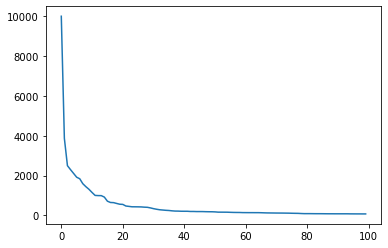

In [9]:
#绘图1

%matplotlib inline

x=[i for i in range(100)]
import matplotlib.pyplot as plt
plt.plot(x,frequiences)

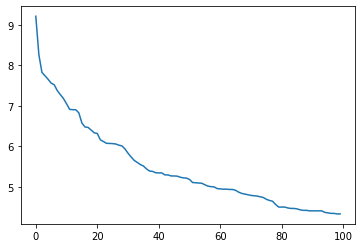

In [10]:
#绘图2

import numpy as np
plt.plot(x,np.log(frequiences))#不输入底数默认以e为底，log10(frequience)就是以10为底

In [11]:
#将词组两两组合生成新的列表

TOKEN = [str(t) for t in TOKEN]
TOKEN_2_GRAM = [''.join(TOKEN[i:i+2]) for i in range(len(TOKEN[:-2]))]
#每两个连续的词组合成一个词
#i从[0,2]、[1,3]、[2,4]...取到[441508,441511]，每两个词一组
TOKEN_2_GRAM[:10]  #连续两个词组成的前十个小组合
words_count_2 = Counter(TOKEN_2_GRAM)

# 3、获取最优语句 

In [12]:
#求句子概率

def prob_1(word):#求一个词的概率
    return words_count[word] / len(TOKEN)#words_count是所有jieba切出来的词及其出现次数的统计，例  '人寿保险': 224

def prob_2(word1, word2):#返回两个词连续发生概率
    if word1 + word2 in words_count_2: 
        return words_count_2[word1+word2] / len(TOKEN_2_GRAM)
    else:
        return 1 / len(TOKEN_2_GRAM)
    
def get_probability(sentence):#返回一个句子的概率
    words = cut(sentence)   #精确模式搜索 
    sentence_pro = 1    
    for i, word in enumerate(words[:-1]):
        next_ = words[i+1]        
        probability = prob_2(word, next_)  #获取相邻两个词同时发生概率      
        sentence_pro *= probability    
    return sentence_pro

need_compared = [
    "我今年1月需要买车险 妈妈明年会买保险",
    "李婷婷会开车 李婷婷不会开卡车",
    "今晚我去参加朋友聚会 今晚我去找老同学",
    "不会开车违反法律 买车不符合法律要求"
]

for s in need_compared:
    s1, s2 = s.split()
    p1, p2 = get_probability(s1), get_probability(s2)
    
    better = s1 if p1 > p2 else s2
    
    print('{} is more possible'.format(better))
    print('-'*4 + ' {} with probility {}'.format(s1, p1))
    print('-'*4 + ' {} with probility {}'.format(s2, p2))

妈妈明年会买保险 is more possible
---- 我今年1月需要买车险 with probility 2.1286512263402824e-30
---- 妈妈明年会买保险 with probility 1.6547650495263087e-20
李婷婷会开车 is more possible
---- 李婷婷会开车 with probility 1.2863767136909423e-10
---- 李婷婷不会开卡车 with probility 1.458989796516851e-15
今晚我去找老同学 is more possible
---- 今晚我去参加朋友聚会 with probility 1.8768104997519636e-25
---- 今晚我去找老同学 with probility 1.6547650495263087e-20
不会开车违反法律 is more possible
---- 不会开车违反法律 with probility 1.458989796516851e-15
---- 买车不符合法律要求 with probility 1.9857180594315702e-19


In [23]:
def generate_best(gram=new_gram,target='war',n=20): 
    sentences = generate_n2(gram,target,n)
    result = []
    for sentence in sentences:
        result.append([sentence, get_probability(sentence)])
    result=sorted(result, key = lambda x:x[1],reverse=True)
    return result[:10]
generate_best()

[['特朗普研发詹姆斯挖掘机轰炸伊朗', 1.8768104997519636e-25],
 ['特朗普引进唐国强纸尿裤制裁唐国强', 1.8768104997519636e-25],
 ['特朗普研发詹姆斯苏打水轰炸伊朗', 1.8768104997519636e-25],
 ['特朗普引进詹姆斯纸尿裤轰炸伊朗', 1.8768104997519636e-25],
 ['特朗普引进詹姆斯纸尿裤制裁佟大为', 2.1286512263402824e-30],
 ['特朗普购买詹姆斯苏打水制裁鲁哈尼', 2.1286512263402824e-30],
 ['特朗普研发佟大为纸尿裤制裁伊朗', 2.1286512263402824e-30],
 ['特朗普购买伊朗挖掘机制裁苏莱曼尼', 2.1286512263402824e-30],
 ['老美研发詹姆斯纸尿裤制裁鲁哈尼', 2.414285322891586e-35],
 ['老美购买伊朗苏打水轰炸鲁哈尼', 2.414285322891586e-35]]